## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
import matplotlib.pyplot as plt
from keras.layers import BatchNormalization, Dropout
from keras.regularizers import l1
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], drp=0, reg=0, bn=0):
    drp_ratio=0.2
    input_layer = keras.layers.Input(input_shape)
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            if reg==1:
                x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1), kernel_regularizer=l1(0.01))(input_layer)
            else:
                x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(input_layer)
            if drp==1:
                x = Dropout(drp_ratio)(x)
            if bn==1:
                x = BatchNormalization()(x)
        else:
            if reg==1:
                x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1), kernel_regularizer=l1(0.01))(x)
            else:
                x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)
            if drp==1:
                x = Dropout(drp_ratio)(x)
            if bn==1:
                x = BatchNormalization()(x)
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
EPOCHS = 50
BATCH_SIZE = 512
MOMENTUM = 0.95
DROPOUT = [0, 1]
REGULAR = [0, 1]
BATCHNORM = [0, 1]

In [7]:
results = {}
for bn, reg, drp in itertools.product(BATCHNORM, REGULAR, DROPOUT):
    model = build_mlp(input_shape=x_train.shape[1:], drp=drp, reg=reg, bn=bn)
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer='adam')
    model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_test, y_test), shuffle=True, verbose=2)

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    exp_name_tag = 'Dropout:'+(' True' if drp==1 else 'False')+' Regular:'+(' True' if reg==1 else 'False')+' BatchNorm:'+(' True' if bn==1 else 'False')
    results[exp_name_tag] = {'train-loss': train_loss, 'valid-loss': valid_loss, 'train-acc': train_acc, 'valid-acc': valid_acc}




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 50000 samples, valida

Epoch 50/50
 - 23s - loss: 0.7195 - acc: 0.7446 - val_loss: 1.5650 - val_acc: 0.5313

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
hidden_

Epoch 11/50
 - 21s - loss: 4.4353 - acc: 0.0980 - val_loss: 4.4348 - val_acc: 0.1000
Epoch 12/50
 - 16s - loss: 4.4361 - acc: 0.0988 - val_loss: 4.4382 - val_acc: 0.1000
Epoch 13/50
 - 17s - loss: 4.4358 - acc: 0.0999 - val_loss: 4.4354 - val_acc: 0.1000
Epoch 14/50
 - 19s - loss: 4.4363 - acc: 0.0987 - val_loss: 4.4512 - val_acc: 0.1000
Epoch 15/50
 - 21s - loss: 4.4352 - acc: 0.0968 - val_loss: 4.4264 - val_acc: 0.1000
Epoch 16/50
 - 20s - loss: 4.4363 - acc: 0.1003 - val_loss: 4.4375 - val_acc: 0.1000
Epoch 17/50
 - 23s - loss: 4.4357 - acc: 0.0976 - val_loss: 4.4314 - val_acc: 0.1000
Epoch 18/50
 - 20s - loss: 4.4358 - acc: 0.0982 - val_loss: 4.4407 - val_acc: 0.1000
Epoch 19/50
 - 25s - loss: 4.4355 - acc: 0.0984 - val_loss: 4.4328 - val_acc: 0.1000
Epoch 20/50
 - 22s - loss: 4.4357 - acc: 0.0995 - val_loss: 4.4399 - val_acc: 0.1000
Epoch 21/50
 - 26s - loss: 4.4354 - acc: 0.0984 - val_loss: 4.4391 - val_acc: 0.1000
Epoch 22/50
 - 25s - loss: 4.4360 - acc: 0.0968 - val_loss: 4.433

Epoch 41/50
 - 17s - loss: 4.4340 - acc: 0.0985 - val_loss: 4.4260 - val_acc: 0.1000
Epoch 42/50
 - 21s - loss: 4.4346 - acc: 0.0989 - val_loss: 4.4315 - val_acc: 0.1000
Epoch 43/50
 - 24s - loss: 4.4345 - acc: 0.0970 - val_loss: 4.4438 - val_acc: 0.1000
Epoch 44/50
 - 24s - loss: 4.4351 - acc: 0.0969 - val_loss: 4.4460 - val_acc: 0.1000
Epoch 45/50
 - 19s - loss: 4.4340 - acc: 0.0981 - val_loss: 4.4250 - val_acc: 0.1000
Epoch 46/50
 - 20s - loss: 4.4352 - acc: 0.0988 - val_loss: 4.4380 - val_acc: 0.1000
Epoch 47/50
 - 21s - loss: 4.4337 - acc: 0.0976 - val_loss: 4.4343 - val_acc: 0.1000
Epoch 48/50
 - 17s - loss: 4.4355 - acc: 0.0982 - val_loss: 4.4341 - val_acc: 0.1000
Epoch 49/50
 - 19s - loss: 4.4343 - acc: 0.0963 - val_loss: 4.4309 - val_acc: 0.1000
Epoch 50/50
 - 18s - loss: 4.4346 - acc: 0.0979 - val_loss: 4.4418 - val_acc: 0.1000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLaye

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
 - 40s - loss: 2.0931 - acc: 0.2805 - val_loss: 1.8643 - val_acc: 0.3174
Epoch 2/50
 - 22s - loss: 1.7914 - acc: 0.3593 - val_loss: 1.8349 - val_acc: 0.3223
Epoch 3/50
 - 30s - loss: 1.7051 - acc: 0.3890 - val_loss: 1.8374 - val_acc: 0.3139
Epoch 4/50
 - 29s - loss: 1.6541 - acc: 0.4045 - val_loss: 1.9341 - val_acc: 0.3220
 - 26s - loss: 1.5740 - acc: 0.4384 - val_loss: 1.6767 - val_acc: 0.3961
Epoch 7/50
 - 26s - loss: 1.5484 - acc: 0.4451 - val_loss: 1.6304 - val_acc: 0.4214
Epoch 8/50
 - 22s - loss: 1.5320 - acc: 0.4509 - val_loss: 1.6607 - val_acc: 0.4061
Epoch 9/50
 - 29s - loss: 1.5125 - acc: 0.4586 - val_loss: 1.6761 - val_acc: 0.4102
Epoch 10/50
 - 26s - loss: 1.5047 - acc: 0.4584 - val_loss: 1.5430 - val_acc: 0.4395
Epoch 11/50
 - 26s - loss: 1.4882 - acc: 0.4681 - val_loss: 1.5067 - val_acc: 0.4555
Epoch 12/50
 - 26s - loss: 1.4687 - acc: 0.4729 - val_loss: 1.4547 - val_acc: 0.4795
Epoch 13/50
 - 27s - loss: 1.4632 

Epoch 35/50
 - 14s - loss: 3.9607 - acc: 0.4053 - val_loss: 4.4282 - val_acc: 0.2701
Epoch 36/50
 - 13s - loss: 3.9525 - acc: 0.4057 - val_loss: 4.1373 - val_acc: 0.3246
Epoch 37/50
 - 12s - loss: 3.9526 - acc: 0.4033 - val_loss: 4.7886 - val_acc: 0.2307
Epoch 38/50
 - 11s - loss: 3.9899 - acc: 0.4058 - val_loss: 5.0099 - val_acc: 0.2252
Epoch 39/50
 - 27s - loss: 3.9722 - acc: 0.4061 - val_loss: 4.5002 - val_acc: 0.2759
Epoch 40/50
 - 20s - loss: 3.9423 - acc: 0.4076 - val_loss: 4.7771 - val_acc: 0.2518
Epoch 41/50
 - 20s - loss: 3.9504 - acc: 0.4073 - val_loss: 5.8423 - val_acc: 0.1770
Epoch 42/50
 - 12s - loss: 3.9821 - acc: 0.4073 - val_loss: 4.7202 - val_acc: 0.2692
Epoch 43/50
 - 10s - loss: 3.9783 - acc: 0.4069 - val_loss: 4.6975 - val_acc: 0.2369
Epoch 44/50
 - 13s - loss: 3.9628 - acc: 0.4046 - val_loss: 4.2211 - val_acc: 0.3270
Epoch 45/50
 - 12s - loss: 3.9494 - acc: 0.4070 - val_loss: 4.3143 - val_acc: 0.3103
Epoch 46/50
 - 12s - loss: 3.9002 - acc: 0.4085 - val_loss: 3.977

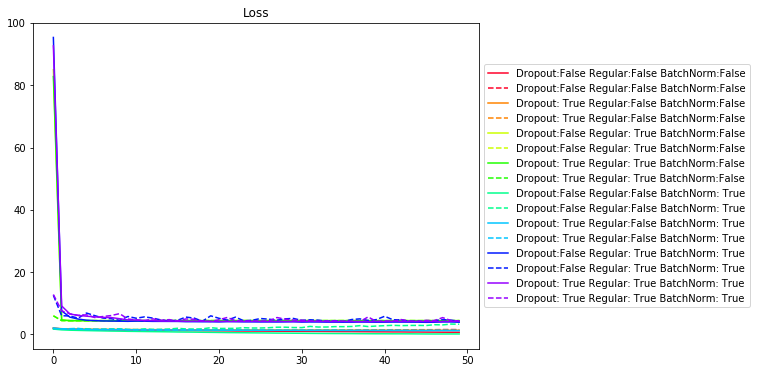

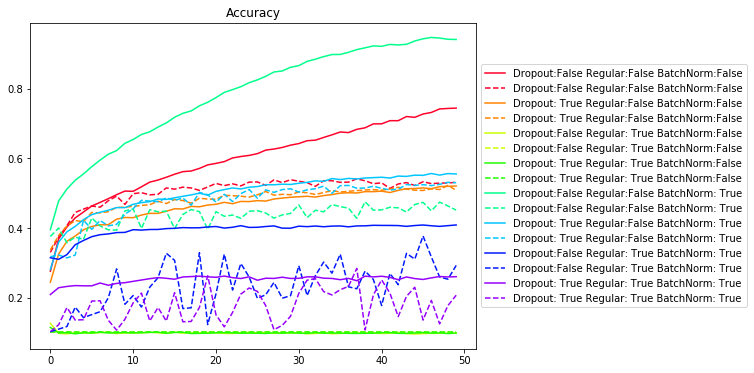

In [8]:
%matplotlib inline
NUM_COLORS = len(results.keys())
cm = plt.get_cmap('gist_rainbow')
color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()